In [1]:
from notebook_helper import *
from helpers import la, space, viz
notebook_setup()
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# Pullution cluster: kitchen sink editions

What happens if we just use *all* the variables avalaible in the beis data? Looks like the result is fine, but a lot more complicated to interpret.  

In [2]:
data_year = 2019

df = pd.read_excel(Path("data", "2005-19_UK_local_and_regional_CO2_emissions.xlsx"),
                   sheet_name="Subset dataset", header=1)
df = df.loc[df["Year"] == data_year].loc[~df["Code"].isna()]
df = df[df.columns[3:-4]]
df = df.drop(columns="Year")

df = (df
      .la.create_code_column(from_type="gss", source_col="Code")
      .drop(columns=["Code"])
      .la.to_current()
      .la.just_principals())

higher_df = df.la.to_higher(aggfunc="sum")

df = pd.concat([df, higher_df])
df = df.set_index("local-authority-code")
df.columns = [x.strip() for x in df.columns]
original = list(df.columns)

In [6]:
used_cols = [x for x in original if "Total" not in x]
 
ndf = df[used_cols]

ndf = ndf.reset_index().la.get_council_info(["region", "pop_2020"])

#convert to per capita emissions
for c in used_cols:
      ndf[c] = (ndf[c]/ndf["pop_2020"])*100

ndf = ndf.drop(columns=["pop_2020"])
ndf["region"] = ndf["region"].fillna("Unknown")
ndf = ndf.set_index("local-authority-code")
ndf.head()

,Industry Electricity,Industry Gas,Industry 'Other Fuels',Large Industrial Installations,Agriculture,Commercial Electricity,Commercial Gas,Commercial 'Other Fuels',Public Sector Electricity,Public Sector Gas,Public Sector 'Other Fuels',Domestic Electricity,Domestic Gas,Domestic 'Other Fuels',Road Transport (A roads),Road Transport (Minor roads),Transport Other,region
local-authority-code,,,,,,,,,,,,,,,,,,
ABC,0.035438,0.044405,0.091834,0.000000,0.031287,0.015872,0.001381,0.001487,0.003480,0.000037,0.000879,0.032167,0.010879,0.133785,0.109193,0.091538,0.001202,Northern Ireland
ABD,0.023206,0.010566,0.044879,0.000504,0.039828,0.025424,0.010887,0.001060,0.004150,0.003604,0.000440,0.042955,0.077202,0.064814,0.145386,0.093629,0.001224,Scotland
ABE,0.018701,0.010538,0.035695,0.000000,0.001408,0.036820,0.030812,0.000271,0.008451,0.033578,0.000340,0.034073,0.111866,0.003344,0.071384,0.059096,0.012151,Scotland
ADU,0.012830,0.003470,0.011730,0.000000,0.001138,0.012443,0.011421,0.000071,0.002368,0.004311,0.000017,0.033532,0.087395,0.005208,0.084628,0.041067,0.020183,South East
AGB,0.021218,0.001375,0.066321,0.000000,0.037711,0.030730,0.019257,0.002624,0.006983,0.009938,0.001252,0.064103,0.071512,0.053284,0.168597,0.042815,0.002557,Scotland


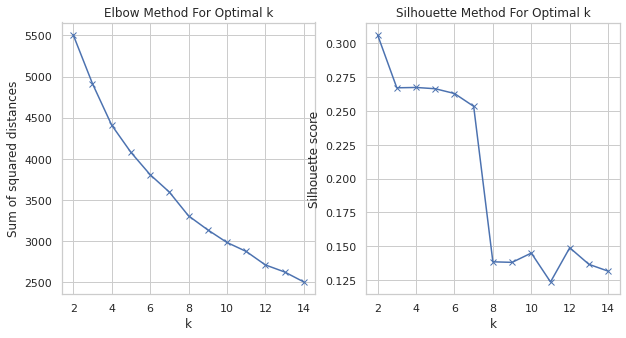

In [11]:
cdf = ndf.drop(index=["LND"]).reset_index()
cluster = space.Cluster(cdf, "local-authority-code", cols=used_cols, normalize=True)
cluster.find_k(2,15)

In [9]:
# seems to be a cluster preference for 7

cluster.set_k(7)
cluster.stats()

,count,%,random members
labels,,,
1,43,10.6,"[WLA, TVCA, STF, RCC, ERY]"
2,14,3.5,"[NMD, POW, MEA, ANN, DRS]"
3,247,61.0,"[SHN, ADU, SWA, HYN, LBH]"
4,1,0.2,[IOS]
5,89,22.0,"[WYC, ESK, WBK, DGY, CWY]"
6,9,2.2,"[CAB, OXO, NTL, CMD, KEC]"
7,2,0.5,"[ORK, ZET]"


Broadly these clusters seem to isolate islands in their own clusters, and then create a few groups that aren't the 'mainstream' group 3. 

This is probably isolating a few more things, but isn't creating 'clear' clusters for the majority of councils, and is harder to explain the differences. 